In [1]:
!nvidia-smi

Fri Jun 18 18:56:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pyrealsense2
import pyrealsense2

     |████████████████████████████████| 16.3MB 162kB/s 


In [3]:
# Utility library and functions for testing the model

import matplotlib
import matplotlib.pyplot as plt
import os
import glob
import random
import cv2
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from google.colab.patches import cv2_imshow
import PIL
import tensorflow as tf

# Upgrade pip to latest version
!pip install pip --upgrade

# Download Object Detection API and build necessary files

%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

%cd /content/models/research/
# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
%cp object_detection/packages/tf2/setup.py .
!python -m pip install --use-feature=2020-resolver .

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

     |████████████████████████████████| 1.6MB 7.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
/content
/content/models/research
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.6 MB 13.5 MB/s 
     |████████████████████████████████| 352 kB 52.8 MB/s 
     |████████████████████████████████| 1.6 MB 55.5 MB/s 
     |████████████████████████████████| 151 kB 73.4 MB/s 
     |████████████████████████████████| 829 kB 55.0 MB/s 
     |████████████████████████████████| 61 kB 9.0 MB/s 
     |██████████████

In [4]:
# If you would like to test the model on your data, 
# create a folder named custom data and manually upload your files here

# !mkdir {DATASET_PATH}custom_data
DATASET_PATH = '/content/drive/Shareddrives/宗聖育葦帶我飛/類神經網路與應用/FinalProject/content/Tensorflow-Object-Detection/'
# DATASET_PATH = '/content/'
# %cd {DATASET_PATH}

# Upload the images from your local files; you can upload multiple images at once

# from google.colab import files
# files.upload()

label_map_pbtxt_fname = DATASET_PATH + 'labelmap.pbtxt'

In [6]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
        path: the file path to the image
    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
            (im_height, im_width, 3)).astype(np.uint8)

def get_model_detection_function(model):
    """Get a tf.function for detection."""

    @tf.function
    def detect_fn(image):
        """Detect objects in image."""

        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])

    return detect_fn

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load the configurations, initialize paths and resotore the export checkpoint

MODEL_TEST = '/content/drive/Shareddrives/宗聖育葦帶我飛/類神經網路與應用/FinalProject/content/Tensorflow-Object-Detection/efficientdet_d0_coco17_tpu-32/export/'

pipeline_config = MODEL_TEST + 'pipeline.config'
model_dir_test = MODEL_TEST + 'checkpoint/ckpt-0'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
            model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(
            model=detection_model)
ckpt.restore(os.path.join(model_dir_test))

In [9]:
# load labelmap, map them to it's labels and load the detector

detect_fn = get_model_detection_function(detection_model)

#map labels for inference decoding
label_map_path = label_map_pbtxt_fname
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
        label_map,
        max_num_classes=label_map_util.get_max_label_map_index(label_map),
        use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

(1168, 1134, 3)
tf.Tensor([0.82924193 0.         0.9980474  0.0400902 ], shape=(4,), dtype=float32)
tf.Tensor(
[0.9834485  0.05605667 0.05597454 0.01670419 0.01615709 0.01566158
 0.01427684 0.0136895  0.01326834 0.01318041 0.01283965 0.01282996
 0.01243199 0.0119611  0.01176453 0.0111259  0.01105079 0.01081056
 0.0107107  0.01068114 0.01055193 0.01052946 0.01046512 0.01046035
 0.01025631 0.00989032 0.00964611 0.0095527  0.00921943 0.00921454
 0.00911143 0.00899906 0.00887504 0.00885316 0.00882455 0.00867685
 0.00865251 0.00862386 0.00846937 0.00842626 0.00839304 0.008373
 0.00830869 0.0082755  0.00816483 0.0081443  0.00810384 0.00808543
 0.00807458 0.00807027 0.00806677 0.00805872 0.00799808 0.00791575
 0.00789244 0.00772878 0.00768791 0.00760034 0.00759645 0.00751433
 0.00750087 0.0074977  0.00748776 0.00727122 0.00727015 0.00724903
 0.0072465  0.00723262 0.00694125 0.00688186 0.00688    0.00686737
 0.00685134 0.00683456 0.00682637 0.006815   0.00681482 0.00679181
 0.00667844 0.006560

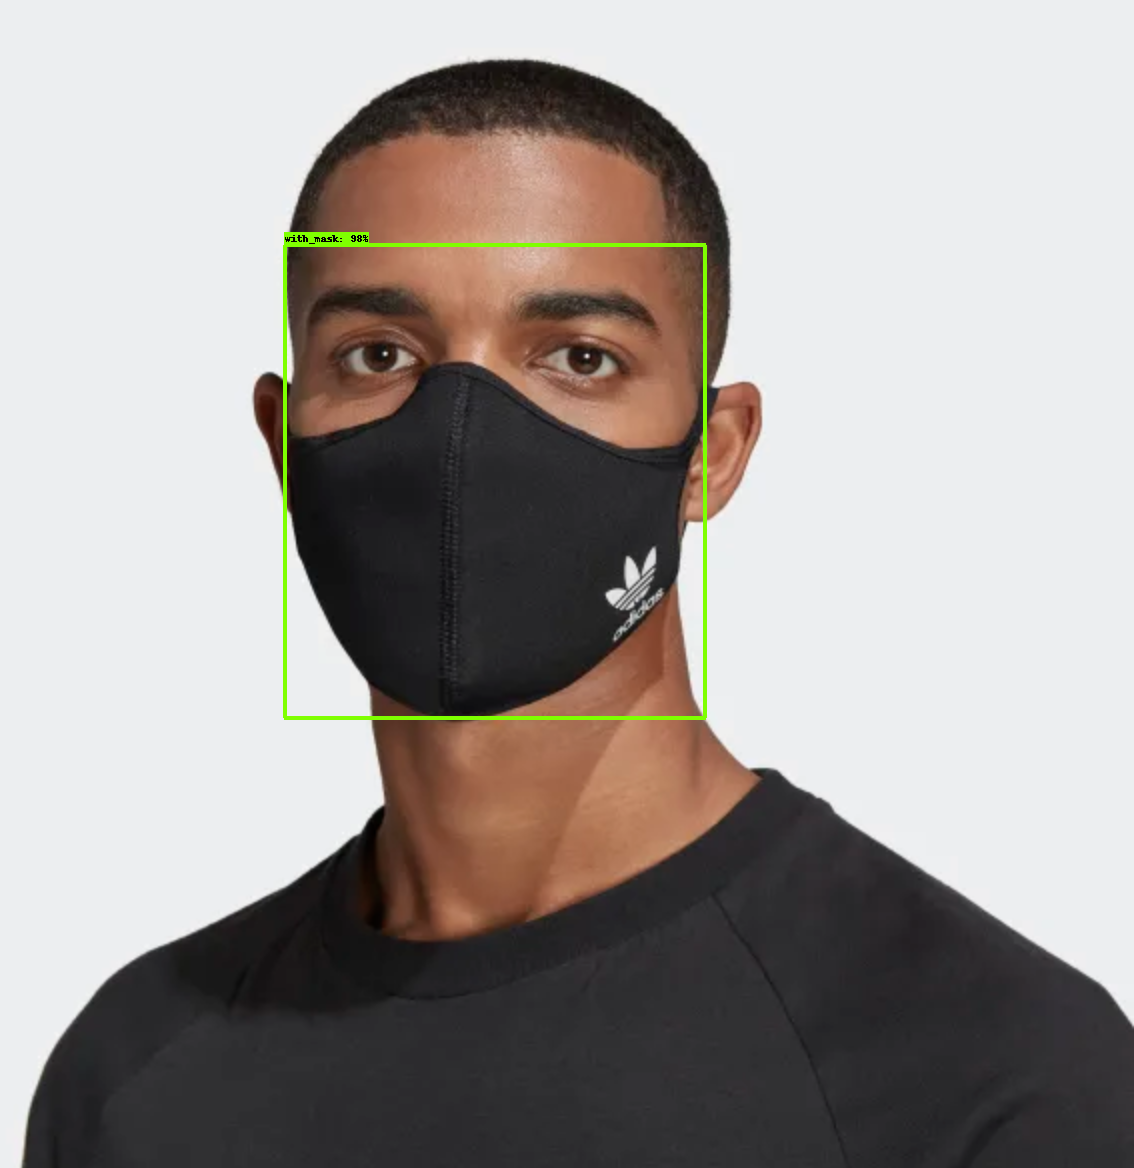

(226, 400, 3)
tf.Tensor([0.00171558 0.76825404 0.02877871 0.7864181 ], shape=(4,), dtype=float32)
tf.Tensor(
[0.9297903  0.90587693 0.887366   0.87651527 0.8732774  0.8560544
 0.8098388  0.8025463  0.79392654 0.7628716  0.75774455 0.7398864
 0.73213947 0.68351203 0.6446532  0.6195178  0.30879855 0.23246695
 0.19520783 0.16086    0.15925293 0.12156535 0.11984134 0.11976624
 0.11952391 0.09896657 0.09407065 0.09392819 0.0931517  0.08788424
 0.08584709 0.08485867 0.08203611 0.08005178 0.07773881 0.07770699
 0.07594448 0.07366818 0.07212875 0.06909894 0.06893162 0.06738377
 0.06604651 0.06310877 0.06225243 0.06103594 0.05950058 0.05929955
 0.05918407 0.05796253 0.05664054 0.05641763 0.05549004 0.05499349
 0.05458539 0.05364242 0.05182381 0.05125283 0.05084579 0.04997908
 0.04905567 0.04893831 0.04841929 0.04797233 0.04771685 0.04754865
 0.04738418 0.0469192  0.04645878 0.04637612 0.04602974 0.04581946
 0.04560545 0.04551899 0.04519392 0.04502937 0.04499118 0.04469263
 0.04429118 0.04413865

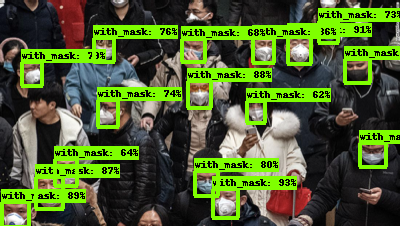

(352, 400, 3)
tf.Tensor([0.29103342 0.         0.41509834 0.0305744 ], shape=(4,), dtype=float32)
tf.Tensor(
[0.95199764 0.9335213  0.8285416  0.18100336 0.09385126 0.08687285
 0.08077416 0.079277   0.06348988 0.05857957 0.05426713 0.0424216
 0.04013761 0.03759795 0.03433697 0.02938568 0.02805202 0.02622059
 0.02351956 0.02172892 0.0209772  0.02043089 0.01961452 0.01919705
 0.01891032 0.01867217 0.0185532  0.01819837 0.01813219 0.01799363
 0.01780492 0.01726898 0.01708429 0.01657686 0.01638338 0.0162347
 0.01589967 0.01569442 0.01565237 0.01509354 0.01478705 0.01431704
 0.014061   0.0138727  0.01364038 0.0136364  0.0136206  0.01358517
 0.01354702 0.01345721 0.01336386 0.01317383 0.01316534 0.01303211
 0.01299895 0.01269843 0.01255114 0.01250209 0.01247032 0.01246356
 0.01235096 0.01227198 0.01227129 0.01217831 0.01207197 0.01203777
 0.01203085 0.01197184 0.01188754 0.01187855 0.01185561 0.01184346
 0.01180091 0.01174644 0.01162307 0.01158721 0.01155829 0.01152076
 0.01148469 0.01145162

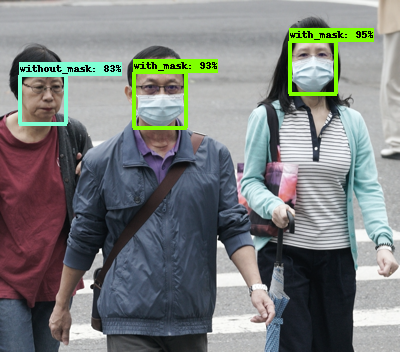

(772, 579, 3)
tf.Tensor([0.         0.         0.45335376 1.        ], shape=(4,), dtype=float32)
tf.Tensor(
[0.95454955 0.12280098 0.07310357 0.01870635 0.01665083 0.01594995
 0.01586683 0.01566476 0.014802   0.01448317 0.01437712 0.01403972
 0.01370005 0.01354465 0.01352459 0.01337735 0.01292203 0.01276655
 0.01244618 0.01226588 0.01226454 0.01212851 0.01205646 0.01193235
 0.01166658 0.01120627 0.01117486 0.01109334 0.01087392 0.01083786
 0.01076798 0.01054042 0.01046946 0.01032045 0.0103181  0.01030542
 0.01026744 0.01012594 0.01012191 0.010095   0.00992276 0.00987768
 0.00950509 0.00939859 0.00938214 0.00909472 0.0090602  0.00900979
 0.00894483 0.00890921 0.00879786 0.0087611  0.00875046 0.00867133
 0.0086423  0.00860413 0.00860263 0.00859288 0.00858623 0.00851682
 0.00849698 0.00840796 0.0083887  0.00830089 0.00820331 0.0081468
 0.0081069  0.00805097 0.00802914 0.00802395 0.00801086 0.00794974
 0.00777224 0.00775026 0.00769589 0.00767799 0.00766405 0.00765813
 0.00765365 0.0076366

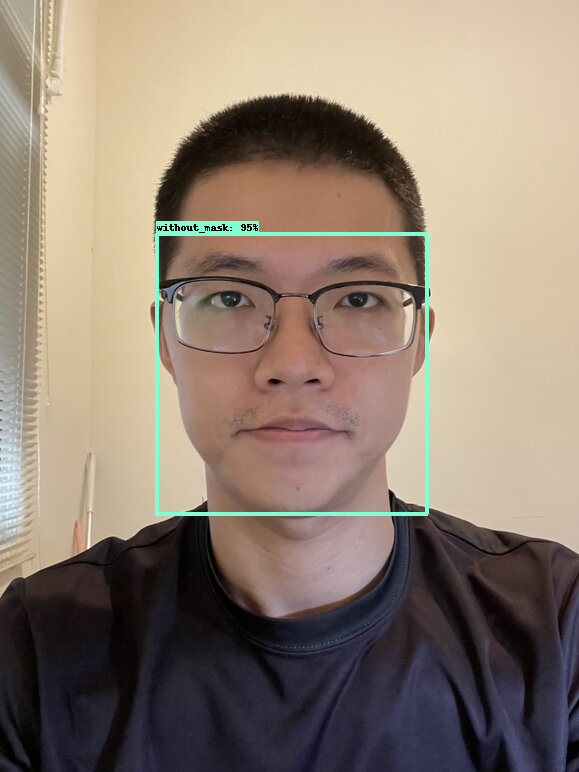

(982, 1702, 3)


tf.Tensor([0.3138002  0.00714828 0.7511369  0.10671018], shape=(4,), dtype=float32)
tf.Tensor(
[0.9221839  0.2517345  0.21002916 0.12570825 0.07818056 0.0734088
 0.05702732 0.05551806 0.05466125 0.0515575  0.03201136 0.02834299
 0.02593986 0.02576812 0.02494168 0.02470906 0.02379246 0.02345822
 0.02309882 0.02142751 0.02084878 0.02057935 0.01911343 0.01899024
 0.01890502 0.01866063 0.01827669 0.01825685 0.01799002 0.01738382
 0.01701591 0.01689585 0.01662344 0.01645006 0.01632615 0.01618101
 0.01606569 0.01601864 0.01592683 0.01583822 0.01579764 0.01579504
 0.01575005 0.01566178 0.0156164  0.01559304 0.01544436 0.01536526
 0.01506935 0.01462923 0.01450871 0.01449744 0.01418891 0.01408117
 0.01407283 0.01397282 0.01392697 0.01385088 0.01384212 0.01379922
 0.01367754 0.01359704 0.01337878 0.01331877 0.01318489 0.01310954
 0.01283103 0.01274883 0.0125839  0.01250424 0.01243468 0.01194378
 0.01191223 0.01186392 0.01175495 0.0116592  0.01157786 0.01146628
 0.01138549 0.01137158 0.01135259 0

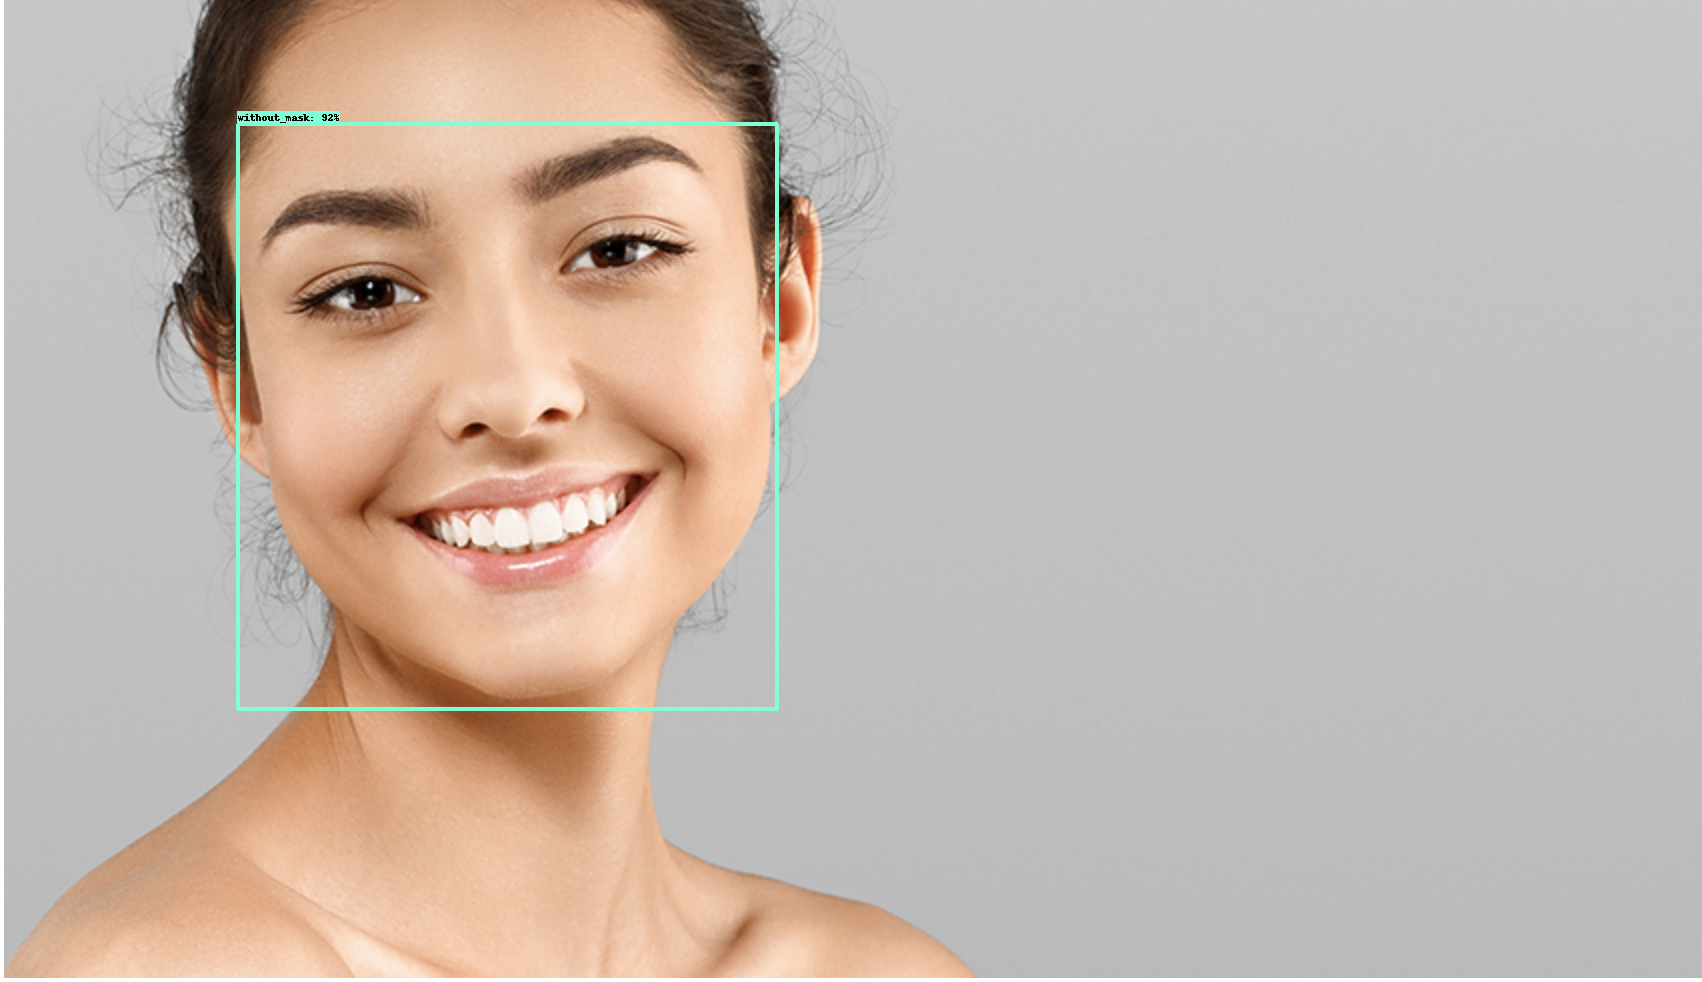

In [10]:
# Test cell

TEST_IMAGE_PATHS = glob.glob('/content/drive/Shareddrives/宗聖育葦帶我飛/類神經網路與應用/FinalProject/TestImage/' + "*.*")

# Change the value of k to the number of images to be considered for testing
try:
    images = random.sample(TEST_IMAGE_PATHS, k=5)
except:
  # Exception incase the value of k is higher than available samples
    images = TEST_IMAGE_PATHS

for image_path in images:

    # image_np = load_image_into_numpy_array(image_path)
    # print(image_np.shape)
    try:
        # image_np = load_image_into_numpy_array(image_path)
        image_np = cv2.imread(image_path)
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        print(image_np.shape)
    except:
        print("Invalid Image format:", image_path)

        continue
    
    input_tensor = tf.convert_to_tensor(
            np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    # print(predictions_dict)
    print(detections['detection_boxes'][0][-1])
    print(detections['detection_scores'][0])

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'][0].numpy(),
                (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
                detections['detection_scores'][0].numpy(),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=.6,
                agnostic_mode=False,
    )

    cv2_imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))


# Removed output to hide my model

In [13]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [51]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [46]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [47]:
def show_distance(event, x, y, args, params):
    global point
    point = (x, y)

point = (400, 300)

def Euclidean_distance(point1, point2):
    dimension = len(point1)
    distance = 0
    # print(point1[0])
    distance = pow(point1[0]-point2[0], 2) + pow(point1[1]-point2[1], 2) + pow(point1[2]-point2[2], 2)
    
    # for i in range(dimension):
    #     distance += pow(point1[i]-point2[i], 2)
    return pow(float(abs(distance)), 0.5)

In [61]:
import pyrealsense2 as rs
import numpy as np

class DepthCamera:
    def __init__(self):
        # Configure depth and color streams
        self.pipeline = rs.pipeline()
        config = rs.config()

        # Get device product line for setting a supporting resolution
        # pipeline_wrapper = rs.pipeline_wrapper(self.pipeline)
        # pipeline_profile = config.resolve(pipeline_wrapper)
        # device = pipeline_profile.get_device()
        # device_product_line = str(device.get_info(rs.camera_info.product_line))

        config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
        config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)



        # Start streaming
        self.pipeline.start(config)

    def get_frame(self):
        frames = self.pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()

        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        if not depth_frame or not color_frame:
            return False, None, None
        return True, depth_image, color_image

    def release(self):
        self.pipeline.stop()

In [62]:
# from realsense_depth import *
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 


capture = DepthCamera()
while True:
    js_reply = video_frame(label_html, bbox)

    print(frame1)
    if not js_reply:
        break

    # convert JS response to OpenCV Image, then to tensor
    frame = js_to_image(js_reply["img"])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(
            np.expand_dims(frame, 0), dtype=tf.float32)

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Detect
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    # print(input_tensor)
    # loop through detections and draw them on transparent overlay image
    # for label, confidence, bbox in detections:
    #   left, top, right, bottom = bbox2points(bbox)
    #   left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    #   bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
    #   bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
    #                     (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
    #                     class_colors[label], 2)

    # bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # # convert overlay of bbox into bytes
    # bbox_bytes = bbox_to_bytes(bbox_array)
    # # update bbox so next frame gets new overlay
    # bbox = bbox_bytes

    label_id_offset = 1
    image_np_with_detections = frame.copy()


    # yolo code #

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    # call our darknet helper on video frame
    # detections, width_ratio, height_ratio = darknet_helper(frame, 640, 480)
    # print(width_ratio, height_ratio)
    # # loop through detections and draw them on transparent overlay image
    width_ratio = 640
    height_ratio = 480
    color_label = [(0, 255, 0), (0, 0, 255), (255, 0, 0)] #RGB
    class_label = ['With mask', 'Mask worn incorrectlyt','Without mask']

    for i in range(100):
      if detections['detection_scores'][0][i] > 0.6:
        # print(detections['detection_scores'][0][i])
        bottom, left, top, right =  int(detections['detection_boxes'][0][i][0] * height_ratio),\
         int(detections['detection_boxes'][0][i][1] * width_ratio),\
          int(detections['detection_boxes'][0][i][2] * height_ratio),\
           int(detections['detection_boxes'][0][i][3] * width_ratio)
        # print(detections['detection_classes'][0][i])
        label = class_label[int(detections['detection_classes'][0][i])]
        color = color_label[int(detections['detection_classes'][0][i])]
        confidence = detections['detection_scores'][0][i]
        # print(left, top, right, bottom)
        bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), color, 2)
        bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                          (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                          color, 2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes     

    # for bbox, label, confidence in detections:
    #   print(bbox)
      # left, top, right, bottom = bbox2points(bbox)
      # print(bbox2points(bbox))
      # left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      # bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      # bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
      #                   (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
      #                   class_colors[label], 2)

    # bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # # convert overlay of bbox into bytes
    # bbox_bytes = bbox_to_bytes(bbox_array)
    # # update bbox so next frame gets new overlay
    # bbox = bbox_bytes


    ########################
    # image_np_with_detections = viz_utils.visualize_boxes_and_labels_on_image_array(
    #             image_np_with_detections,
    #             detections['detection_boxes'][0].numpy(),
    #             (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    #             detections['detection_scores'][0].numpy(),
    #             category_index,
    #             use_normalized_coordinates=True,
    #             max_boxes_to_draw=200,
    #             min_score_thresh=.6,
    #             agnostic_mode=False,
    # )

    # cv2_imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    # convert overlay of bbox into bytes
    # bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    # bbox = bbox_bytes

<IPython.core.display.Javascript object>

RuntimeError: ignored